In [1]:
!pip install numpy gym[atari] gymnasium ale-py opencv-python matplotlib torch torchvision tqdm



In [2]:
!pip install gym[accept-rom-license] gym[atari] ale-py


In [3]:
!pip install --upgrade gym

In [4]:
# import ale_py
!ale-import-roms


usage: ale-import-roms [-h] [--version] [--dry-run] (--import-from-pkg IMPORT_FROM_PKG | romdir)
ale-import-roms: error: one of the arguments --import-from-pkg romdir is required


In [5]:
import gym
env = gym.make("PongDeterministic-v4")
print("Environment loaded successfully!")

Environment loaded successfully!


In [6]:
import cv2
import numpy as np

def preprocess_frame(frame):
    """
    Preprocesses the game frame:
    - Converts to grayscale
    - Crops irrelevant parts
    - Resizes to 84x80
    - Normalizes pixel values to [-1, 1]
    """
    frame = frame[30:-12, :, :]  # Crop (removes top and bottom borders)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, (80, 84), interpolation=cv2.INTER_AREA)  # Resize
    frame = frame.astype(np.float32) / 128 - 1  # Normalize to [-1, 1]

    return frame


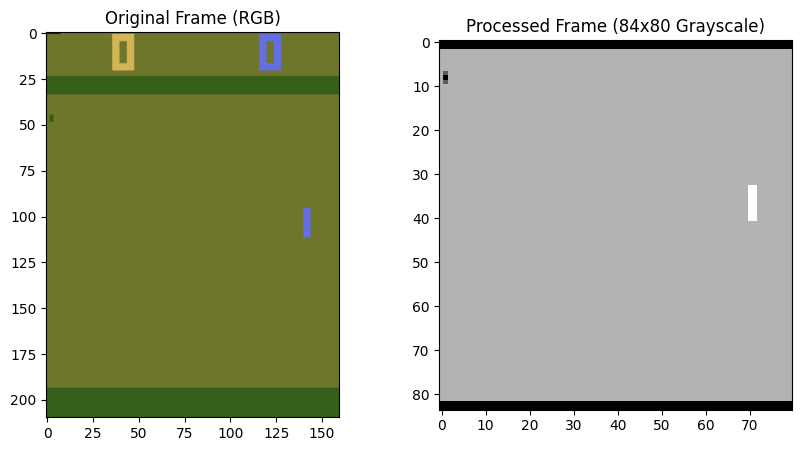

In [7]:
import gym
import matplotlib.pyplot as plt

# Load Pong environment
env = gym.make("PongDeterministic-v4", render_mode="rgb_array")

# Reset environment and get first frame
state = env.reset()[0]
processed_frame = preprocess_frame(state)

# Show original vs. processed frame
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(state)  # Original RGB image
axes[0].set_title("Original Frame (RGB)")
axes[1].imshow(processed_frame, cmap="gray")  # Grayscale processed image
axes[1].set_title("Processed Frame (84x80 Grayscale)")
plt.show()


In [8]:
from collections import deque

class FrameStack:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)  # Store last 4 frames

    def reset(self, initial_frame):
        """Initializes frame stack with 4 copies of the first frame."""
        self.frames.clear()
        for _ in range(self.stack_size):
            self.frames.append(initial_frame)
        return np.stack(self.frames, axis=0)  # Shape: (4, 84, 80)

    def add_frame(self, new_frame):
        """Adds a new frame and removes the oldest one."""
        self.frames.append(new_frame)
        return np.stack(self.frames, axis=0)  # Shape: (4, 84, 80)

In [9]:
import types  # Import types for function manipulation

# Reset environment
state = env.reset()[0]

# Preprocess the initial frame
processed_frame = preprocess_frame(state)

# Initialize frame stack
frame_stack = FrameStack()

# Create the first stacked state (4 identical frames)
stacked_state = frame_stack.reset(processed_frame)

# Monkey-patch the step method
_original_step = env.unwrapped.step  # Store original step method

def patched_step(self, action):
    # Call the ORIGINAL step method of the environment, passing only action
    next_state, reward, done, truncated, info = _original_step(action)
    # Convert done to Python bool to avoid np.bool8 issue
    done = bool(done)
    return next_state, reward, done, truncated, info

# Apply the patch
env.step = types.MethodType(patched_step, env)

# Now you can use env.step() as before
action = env.action_space.sample()
next_state, reward, done, _, _ = env.step(action)

# Process new frame and add it to the stack
processed_next_frame = preprocess_frame(next_state)
stacked_next_state = frame_stack.add_frame(processed_next_frame)

# Print shape (should be 4, 84, 80)
print("Stacked Frame Shape:", stacked_next_state.shape)

Stacked Frame Shape: (4, 84, 80)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Calculate flattened size dynamically using a test input
        test_input = torch.zeros(1, input_dim, 84, 80)  # Create a dummy input
        with torch.no_grad():  # Disable gradient calculation for this step
            test_output = self.conv_layers(test_input)  # Pass through conv layers
            self.fc_input_size = test_output.numel()  # Get the flattened size

        # Fully connected layers for Q-value prediction
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, output_dim)

    def conv_layers(self, x):
        """Helper function for convolutional layers"""
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        return x

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through convolutional layers
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Output Q-values for each action

In [11]:
# Initialize DQN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(input_dim=4, output_dim=6).to(device)

# Generate a random input tensor (batch of 1 frame stack)
sample_input = torch.randn(1, 4, 84, 80).to(device)

# Pass input through the network
output = model(sample_input)
print("Q-Values Output Shape:", output.shape)  # Expected: (1, 6)


Q-Values Output Shape: torch.Size([1, 6])


In [12]:
import random
from collections import deque

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)  # Store experience tuples

    def push(self, state, action, reward, next_state, done):
        """Stores an experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Randomly samples a batch of experiences for training."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Returns the current memory size."""
        return len(self.memory)


In [13]:
# Initialize replay memory with a capacity of 50,000 experiences
memory = ReplayMemory(50000)

# Push a random experience
memory.push(stacked_state, action, reward, stacked_next_state, done)

# Check if it stores correctly
print("Memory Size:", len(memory))

# Sample a batch of 8 experiences
if len(memory) >= 8:
    batch = memory.sample(8)
    print("Sampled Batch Size:", len(batch))


Memory Size: 1


In [14]:
def compute_loss(batch, policy_net, target_net, optimizer, gamma=0.95):
    """
    Computes the DQN loss function using Mean Squared Error (MSE).
    """
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convert to PyTorch tensors
    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    # Get Q-values from the policy network
    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Get the max Q-value from the target network (detach to prevent gradients)
    next_q_values = target_net(next_states).max(1)[0].detach()

    # Compute the expected Q-values using the Bellman equation
    expected_q_values = rewards + gamma * next_q_values * (1 - dones)

    # Compute loss (Mean Squared Error)
    loss = nn.MSELoss()(q_values, expected_q_values)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [15]:
import torch

# 🔹 Clear GPU cache to prevent memory leaks
torch.cuda.empty_cache()

In [16]:
import os
import pickle
from tqdm import tqdm
import time  # Import time for sleep

# ... (Other imports and functions - DQN, ReplayMemory, preprocess_frame, etc. - remain the same) ...

def train_agent(env, num_episodes=500, checkpoint_path="dqn_checkpoint.pth",
                 render_every=10, resume_training=False, batch_size=8, update_target_rate=10):
    """
    Train the agent, log metrics, save progress, and render the environment periodically.
    """
    policy_net = DQN(4, 6).to(device)
    target_net = DQN(4, 6).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=0.00025)
    memory = ReplayMemory(10000)

    env.metadata['render_fps'] = 60  # <--- Insert this line here to attempt to set metadata
    # ⭐️ Resume training variables ⭐️
    start_episode = 0
    scores_per_episode = []
    avg_rewards = []

    if resume_training and os.path.exists(checkpoint_path):
        print("✅ Resuming training from checkpoint...")
        checkpoint = torch.load(checkpoint_path)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_episode = checkpoint['episode'] + 1
        epsilon = checkpoint['epsilon']
        batch_size = checkpoint.get('batch_size', batch_size)  # Get batch size from checkpoint or use default
        update_target_rate = checkpoint.get('update_target_rate', update_target_rate)  # Get update rate or use default

        # Load training data if it exists
        data_path = f"training_data_batch{batch_size}_update{update_target_rate}.pkl"
        if os.path.exists(data_path):
            with open(data_path, "rb") as f:
                data = pickle.load(f)
                scores_per_episode = data.get('scores', [])
                avg_rewards = data.get('avg_rewards', [])

    else:
        # ⭐️ Hyperparameters (Updated) ⭐️
        epsilon = 1.0  # Exploration Factor Initial Value (ϵinit)
        decay = 0.995  # Exploration Decay Rate (δ)
        epsilon_min = 0.05  # Exploration minimum value (ϵmin)

    gamma = 0.95  # Discount Factor (γ)
    save_interval = 10  # save interval for model

    progress_bar = tqdm(range(start_episode, num_episodes), desc="Training Progress", position=0, leave=True)

    for episode in progress_bar:
        state = preprocess_frame(env.reset()[0])
        frame_stack = FrameStack()
        state_stack = frame_stack.reset(state)

        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                with torch.no_grad():
                    action = policy_net(torch.tensor(state_stack, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()

            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_frame(next_state)
            stacked_next_state = frame_stack.add_frame(next_state)

            memory.push(state_stack, action, reward, stacked_next_state, done)  # Fixed typo here
            state_stack = stacked_next_state
            total_reward += reward

            if len(memory) > batch_size:
                batch = memory.sample(batch_size)
                compute_loss(batch, policy_net, target_net, optimizer, gamma)

            # ⭐️ Visualization added here ⭐️
            if episode % render_every == 0:
                env.render()
                time.sleep(1/60)  # Adjust sleep time as needed

        if episode % update_target_rate == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon * decay, epsilon_min)
        scores_per_episode.append(total_reward)
        avg_reward = np.mean(scores_per_episode[-5:]) if len(scores_per_episode) >= 5 else np.mean(scores_per_episode)
        avg_rewards.append(avg_reward)

        progress_bar.set_postfix({"Ep Score": total_reward, "Avg(5)": avg_reward, "Epsilon": epsilon})

        if episode % save_interval == 0:
            checkpoint = {
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epsilon': epsilon,
                'batch_size': batch_size,
                'update_target_rate': update_target_rate
            }
            torch.save(checkpoint, checkpoint_path)

            # Save training data with hyperparameters
            with open(f"training_data_batch{batch_size}_update{update_target_rate}.pkl", "wb") as f:
                pickle.dump({
                    'scores': scores_per_episode,
                    'avg_rewards': avg_rewards,
                    'batch_size': batch_size,
                    'update_target_rate': update_target_rate
                }, f)

    # ... (Save final model and data - remain the same) ...
    torch.save(policy_net.state_dict(), "final_dqn_model.pth")
    print("✅ Final trained model saved as final_dqn_model.pth")

    return policy_net, scores_per_episode, avg_rewards

In [17]:
# Default settings (batch_size=8, update_target_rate=10)
trained_model_default, scores_default, avg_rewards_default = train_agent(env, num_episodes=500)



Training Progress: 100%|██████████| 500/500 [1:52:47<00:00, 13.54s/it, Ep Score=-7, Avg(5)=-10.4, Epsilon=0.0816]

✅ Final trained model saved as final_dqn_model.pth


In [20]:
# Batch size 16
trained_model_batch16, scores_batch16, avg_rewards_batch16 = train_agent(env, num_episodes=500, batch_size=16)

# Save the model with a separate name
torch.save(trained_model_batch16.state_dict(), "dqn_model_batch16.pth")
print("✅ Model saved as dqn_model_batch16.pth")



Training Progress: 100%|██████████| 500/500 [2:17:26<00:00, 16.49s/it, Ep Score=8, Avg(5)=-0.4, Epsilon=0.0816]

✅ Final trained model saved as final_dqn_model.pth
✅ Model saved as dqn_model_batch16.pth


In [23]:
# Update rate 3
trained_model_update3, scores_update3, avg_rewards_update3 = train_agent(env, num_episodes=500, update_target_rate=3)



Training Progress: 100%|██████████| 500/500 [2:15:04<00:00, 16.21s/it, Ep Score=6, Avg(5)=4, Epsilon=0.0816]

✅ Final trained model saved as final_dqn_model.pth


In [25]:
# Define the paths for all training data files
file_paths = {
    "Batch 8, Update 10": "./training_data_batch8_update10.pkl",
    "Batch 16, Update 10": "./training_data_batch16_update10.pkl",
    "Batch 8, Update 3": "./training_data_batch8_update3.pkl"
}

# Store the data for the combined plot
all_scores = {}
all_avg_rewards = {}

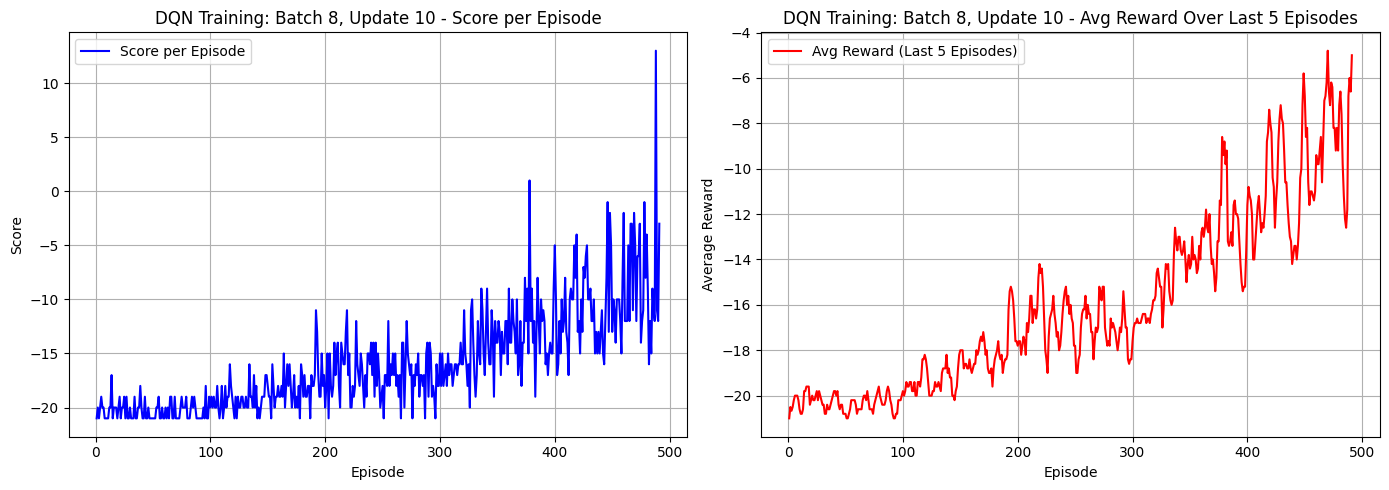

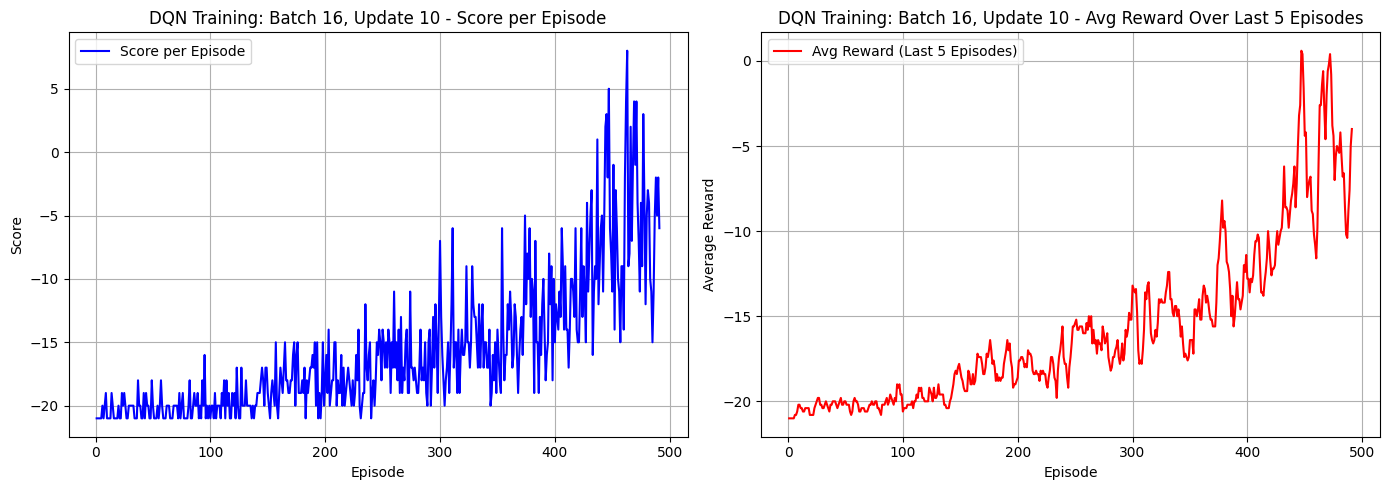

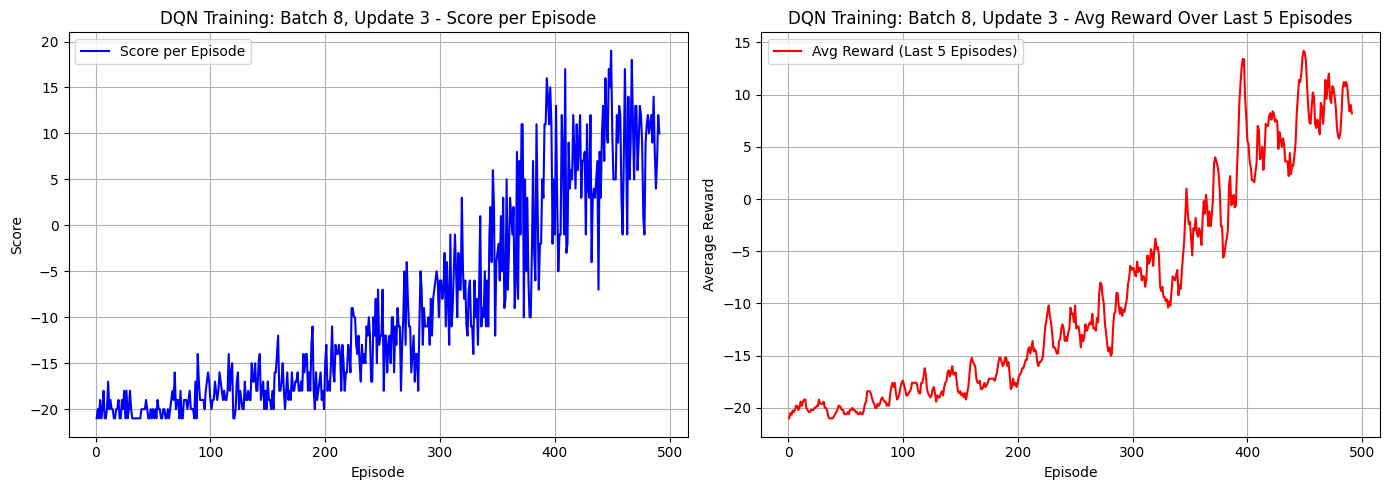

In [26]:
# Load each dataset and plot individually
for label, path in file_paths.items():
    try:
        with open(path, "rb") as f:
            loaded_data = pickle.load(f)

        if isinstance(loaded_data, dict):
            scores_per_episode = loaded_data.get("scores", [])
            avg_rewards = loaded_data.get("avg_rewards", [])

            # Store for combined plot
            all_scores[label] = scores_per_episode
            all_avg_rewards[label] = avg_rewards

            # Create plots for each dataset
            plt.figure(figsize=(14, 5))

            # 📌 Plot 1: Score per Episode
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(scores_per_episode) + 1), scores_per_episode, label="Score per Episode", color="blue")
            plt.xlabel("Episode")
            plt.ylabel("Score")
            plt.title(f"DQN Training: {label} - Score per Episode")
            plt.legend()
            plt.grid()

            # 📌 Plot 2: Average Cumulative Reward (Last 5 Episodes)
            plt.subplot(1, 2, 2)
            plt.plot(range(1, len(avg_rewards) + 1), avg_rewards, label="Avg Reward (Last 5 Episodes)", color="red")
            plt.xlabel("Episode")
            plt.ylabel("Average Reward")
            plt.title(f"DQN Training: {label} - Avg Reward Over Last 5 Episodes")
            plt.legend()
            plt.grid()

            # Show plots
            plt.tight_layout()
            plt.show()

    except FileNotFoundError:
        print(f"⚠️ File not found: {path}")


In [27]:
# Load data from files
data_dict = {}
for label, path in file_paths.items():
    with open(path, "rb") as f:
        data_dict[label] = pickle.load(f)

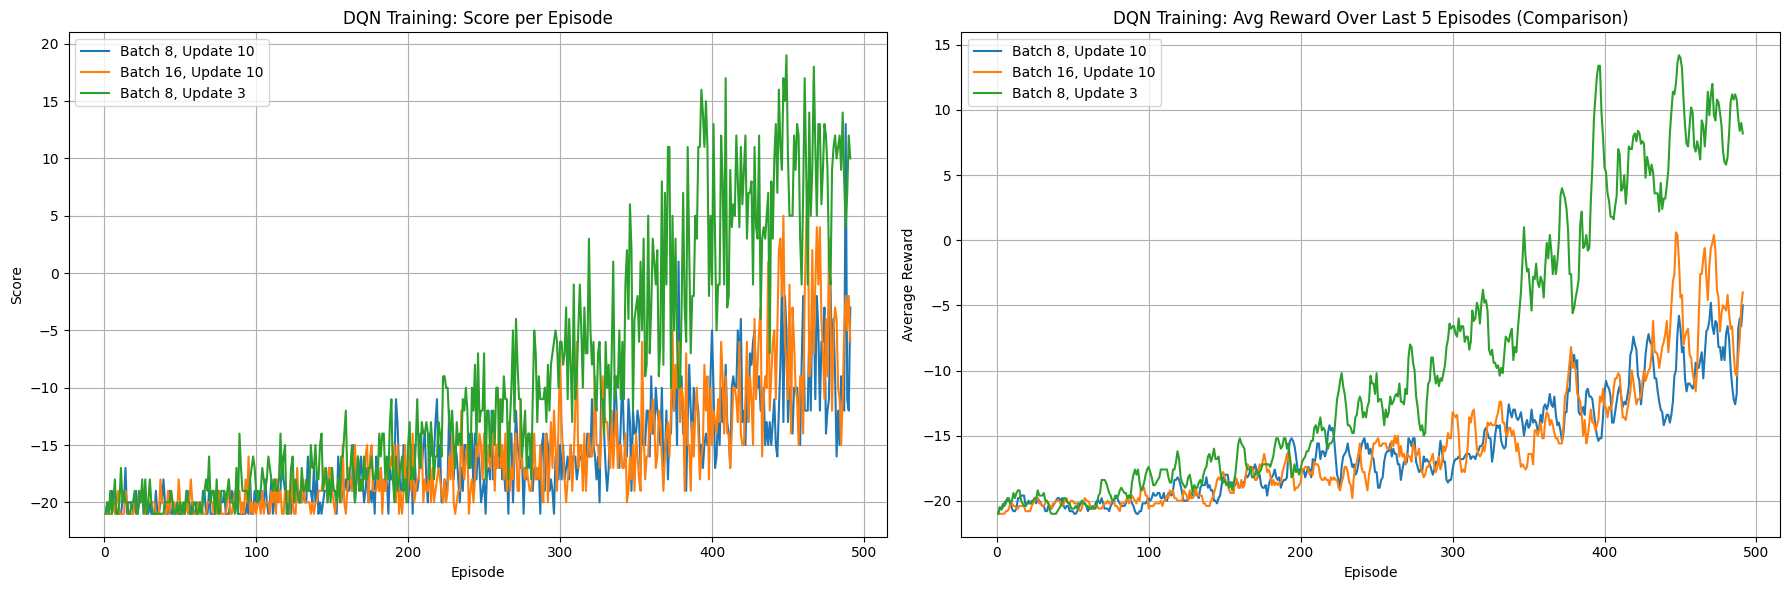

In [28]:

# Set figure size for better spacing
plt.figure(figsize=(18, 6))  # Increased width

# 📌 Plot 1: Score per Episode
plt.subplot(1, 2, 1)
for label, data in data_dict.items():
    scores_per_episode = data.get("scores", [])
    plt.plot(range(1, len(scores_per_episode) + 1), scores_per_episode, label=label)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("DQN Training: Score per Episode")
plt.legend()
plt.grid()

# 📌 Plot 2: Average Cumulative Reward (Last 5 Episodes)
plt.subplot(1, 2, 2)
for label, data in data_dict.items():
    avg_rewards = data.get("avg_rewards", [])
    plt.plot(range(1, len(avg_rewards) + 1), avg_rewards, label=label)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("DQN Training: Avg Reward Over Last 5 Episodes (Comparison)")
plt.legend()
plt.grid()

# 🔹 Show the plots
plt.tight_layout()
plt.show()